# 3.2 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.1498, 0.1996]) 
label: tensor([3.8282])


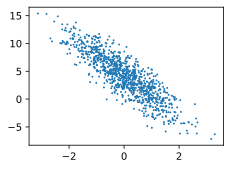

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5374, -1.0131],
        [ 0.2572,  0.9375],
        [-0.6197, -0.5885],
        [ 0.2620, -0.9191],
        [ 1.1839, -0.3735],
        [-0.3180,  0.9719],
        [ 0.8825,  0.0921],
        [ 0.8603,  1.0738],
        [-0.0364, -0.8736],
        [ 1.8131,  0.5018]]) 
 tensor([[6.5642],
        [1.5350],
        [4.9546],
        [7.8573],
        [7.8234],
        [0.2473],
        [5.6382],
        [2.2502],
        [7.0993],
        [6.1330]])


In [13]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [15]:
# 模型定义
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037622
epoch 2, loss 0.000141
epoch 3, loss 0.000054


In [ ]:
print(f'w 的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b 的估计误差: {true_b - b}')

w的估计误差: tensor([ 8.4400e-05, -8.9169e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


## 练习题

练习题 1：如果我们将权重初始化为零，会发生什么。算法仍然有效吗

对于此例子来说影响不大。但对更复杂的网络会出现对称性，会影响最后的训练结果。

In [18]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w 的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b 的估计误差: {true_b - b}')

epoch 1, loss 0.037533
epoch 2, loss 0.000136
epoch 3, loss 0.000054
w 的估计误差: tensor([ 0.0001, -0.0003], grad_fn=<SubBackward0>)
b 的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


练习题 2：假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗

因为 $U = w I + b$，电流与电压成线性关系，因此可以。

练习题 3：能基于普朗克定律使用光谱能量密度来确定物体的温度吗

$$
u_\lambda (\lambda, T)= (8\pi hc / \lambda^5)/(e^{(hc/\lambda kT)} - 1)
$$

u 与 T 之间是线性关系，是正比，因此可以。

练习题 4：计算二阶导数时可能会遇到什么问题？这些问题可以如何解决

可能遇到的问题：

* 二阶导数计算上比一阶导数更加复杂，花费时间更多
* 高阶导数的计算通常涉及到构建更复杂的计算图，可能导致内存消耗较大

解决方法：

* 使用现代的深度学习框架

练习题 5：为什么在 `squared_loss` 函数中需要使用 `reshape` 函数

`y_hat` 是向量，`y` 是十行一列的矩阵，所以需要 reshape 之后进行比较。

练习题 6：尝试使用不同的学习率，观察损失函数值下降的快慢

* 学习率大：模型参数更新快、损失函数下降快、可能导致损失震荡或不稳定
* 学习率小：模型参数更新慢、损失函数下降慢、可能导致训练慢或者陷入局部最小值

练习题 7：如果样本个数不能被批量大小整除，`data_iter` 函数的行为会有什么变化

最后一组会由剩下的元素构成。